In [16]:
import csv
import math
import sys, time
import networkx as nx
import numpy as np
import collections
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *

In [17]:
G = nx.Graph()
pos = {}
site = {}

with open('nodes_cost266.csv', 'r') as f_node:
# with open('w_node.csv', 'r') as f_node:
    reader = csv.DictReader(f_node, delimiter=';', quotechar="'")
    for row in reader:
        node = int(row['node'])
        site_node = row['site']
        x_coord = float(row['X'])
        y_coord = float(row['Y'])
        G.add_node(node,site=site_node)
        pos[node] = [x_coord,y_coord]
        site[node] = site_node

In [18]:
with open('edges_cost266.csv', 'r') as f_edge:
# with open('w_edge.csv', 'r') as f_edge:
    reader = csv.DictReader(f_edge, delimiter=';', quotechar="'")
    for row in reader:
        nodeA = int(row['nodeA'])
        nodeB = int(row['nodeB'])
        G.add_edge(nodeA,nodeB)        
        G[nodeA][nodeB]['capa'] = float(row['capa'])

In [19]:
H = nx.DiGraph(G)
capa = {}

for (u,v) in G.edges():
    capa[(u,v)] = G[u][v]['capa']
    capa[(v,u)] = G[u][v]['capa']

In [20]:
K = nx.DiGraph()

with open('demand_cost266.csv', 'r') as f_demand:
# with open('w_demand.csv', 'r') as f_demand:
    reader = csv.DictReader(f_demand, delimiter=';', quotechar="'")
    for row in reader:
        nodeA = int(row['nodeA'])
        nodeB = int(row['nodeB'])
        if nodeA > nodeB:
            tmp = nodeA
            nodeA = nodeB
            nodeB = tmp
            
        K.add_edge(nodeA,nodeB)                    
        K[nodeA][nodeB]['demand'] = float(row['demand'])/25.0 #Pour arriver à des taux de charges raisonnables
        # K[nodeA][nodeB]['demand'] = float(row['demand'])
        # print(float(row['demand']))

In [21]:
print(len(G.nodes()),'nodes')
print(len(G.edges()),'edges')
print(len(K.edges()),'demands')

37 nodes
57 edges
36 demands


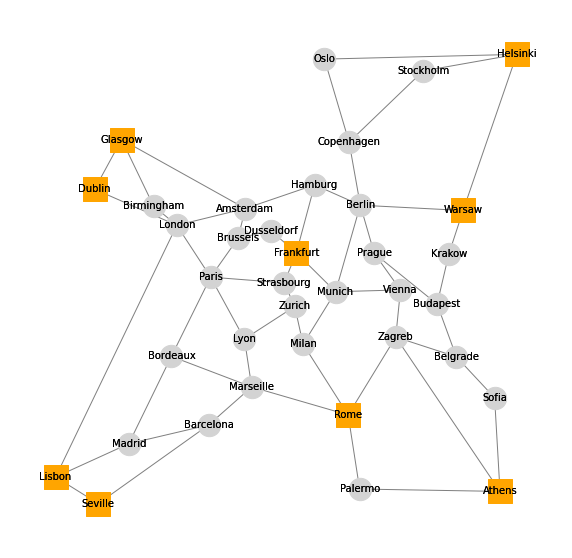

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,10));
plt.axis('off')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')

nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')

In [23]:
# +++ Flow Conservation constraints +++
def flowConservation(model, node, o, d):
    inFlow = sum(
        model.flow[i, j, o, d]
        for (i, j) in model.arcs
        if j == node
    )
    outFlow = sum(
        model.flow[i, j, o, d]
        for (i, j) in model.arcs
        if i == node
    )
    if node == o:
        return (inFlow - outFlow + K[o][d]['demand'] == 0)
    elif node == d:
        return (inFlow - outFlow - K[o][d]['demand'] == 0)
    else:
        return (inFlow == outFlow)


In [24]:
#+++ Capacity constraints +++
def linkCapacity(model, i, j):
    expression = sum(model.flow[i,j,o,d] + model.flow[j,i,o,d] for (o,d) in model.demands)<= model.capa[i,j] * model.gamma
    return expression

In [25]:
solver = 'cplex'

print('>>> Loading optimization model')

model = ConcreteModel()

model.dual = Suffix(direction=Suffix.IMPORT)

model.nodes   = H.nodes()
model.links   = G.edges()
model.arcs    = H.edges()
model.demands = K.edges()

model.index1 = Set(initialize=[(u, o, d) for u in model.nodes for (o, d) in model.demands])
model.index2 = Set(initialize=[(u, v, o, d) for (u, v) in model.arcs for (o, d) in model.demands])

model.capa = Param(model.arcs, initialize=capa)

model.flow  = Var(model.index2, domain=NonNegativeReals)
model.gamma = Var(domain=NonNegativeReals)

model.objective = Objective(rule=lambda m: m.gamma, sense=minimize)

model.flowConserv = Constraint(model.index1, rule=flowConservation)

model.linkCapa = Constraint(model.links, rule=linkCapacity)


>>> Loading optimization model


In [26]:
print('>>> Solving optimization model')
    
# model.preprocess()

optim = SolverFactory(solver)
    
start_time = time.time()

results = optim.solve(model)
    
cpu_time = time.time() - start_time

print('+ TERM STAT:',results.solver.status)
print('+ TERM COND:',results.solver.termination_condition)
    
print('+ CPU  TIME = {0:.2f} s'.format(cpu_time))

if results.solver.status == SolverStatus.ok and results.solver.termination_condition != TerminationCondition.infeasible:
    print('+ OPT VAL  = {0:.8f}'.format(model.gamma.value))
    print('+ LWR BND  = {0:.2f}'.format(results.Problem._list[0]['Lower bound']))

>>> Solving optimization model
+ TERM STAT: ok
+ TERM COND: optimal
+ CPU  TIME = 0.59 s
+ OPT VAL  = 0.68820000
+ LWR BND  = 0.69


In [27]:
epsilon = 1.0e-06

load = {}
    
for (u,v) in G.edges():
    TotalFlow = 0.0
    for (o,d) in K.edges():
        TotalFlow += model.flow[u,v,o,d].value  #On somme pour chaque lien le flow qui passe
        TotalFlow += model.flow[v,u,o,d].value
    G[u][v]['flow'] = TotalFlow    
    if TotalFlow > epsilon:
        load[(u,v)] = 100*TotalFlow/model.capa[(u,v)]
        # print(load[(u,v)])
        print('link ({0:10s},{1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow,model.capa[(u,v)],load[(u,v)]))
        #print('link ({0:10s},{1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow,model.capa[(u,v)],100*TotalFlow/model.capa[(u,v)]))
    else:
        load[(u,v)] = 0.0

link (Amsterdam ,Brussels  ):	flow = 137.640000 / capacity = 200.000000 -> load = 68.82 %
link (Amsterdam ,London    ):	flow = 130.830000 / capacity = 250.000000 -> load = 52.33 %
link (Amsterdam ,Glasgow   ):	flow = 172.050000 / capacity = 250.000000 -> load = 68.82 %
link (Amsterdam ,Hamburg   ):	flow = 106.500000 / capacity = 250.000000 -> load = 42.60 %
link (Athens    ,Palermo   ):	flow = 25.840000 / capacity = 300.000000 -> load = 8.61 %
link (Athens    ,Zagreb    ):	flow = 37.980000 / capacity = 250.000000 -> load = 15.19 %
link (Athens    ,Sofia     ):	flow = 61.860000 / capacity = 200.000000 -> load = 30.93 %
link (Barcelona ,Seville   ):	flow = 98.750000 / capacity = 200.000000 -> load = 49.37 %
link (Barcelona ,Madrid    ):	flow = 51.770000 / capacity = 200.000000 -> load = 25.89 %
link (Barcelona ,Marseille ):	flow = 100.040000 / capacity = 200.000000 -> load = 50.02 %
link (Belgrade  ,Budapest  ):	flow = 68.820000 / capacity = 100.000000 -> load = 68.82 %
link (Belgrade  ,

In [28]:
model.gamma.value
load1 = {}
G1 = G.copy()
Saturated_edge = []

print('____ Saturated Edges _____ ' )
for (u,v) in G1.edges():
    TotalFlow1 = 0.0
    for (o,d) in K.edges():
        TotalFlow1 += model.flow[u,v,o,d].value  #On somme pour chaque lien le flow qui passe
        TotalFlow1 += model.flow[v,u,o,d].value
    G1[u][v]['flow'] = TotalFlow1    
    if abs(100*TotalFlow1/model.capa[(u,v)] - model.gamma.value*100) < epsilon:
        Saturated_edge.append((u,v))
        load1[(u,v)] = 100*TotalFlow1/model.capa[(u,v)]
        print('link ({0:10s}, {1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow1,model.capa[(u,v)],load1[(u,v)]))
        # model.capa[(u,v)] *= 0.9

# print(Saturated_edge)
def isSaturated(uv):
    isAttained = np.zeros(len(G.edges))
    queue = collections.deque()
    u = uv[0]
    v = uv[1]
    isAttained[u] = 1
    for n in G.neighbors(u) : 
        if n not in queue and  abs(load[min(u,n), max(u,n)]  - model.gamma.value*100) > epsilon:
            queue.append(n)
    # for n in G.neighbors(u):
    #     if n not in queue:
    #         queue.append(n)
    while isAttained[v] == 0 and len(queue) != 0:
        n = queue.popleft()
        isAttained[n] = 1
        for n1 in G.neighbors(n) :
            if (n1 not in queue) and (isAttained[n1] == 0) and abs(load[min(n,n1), max(n,n1)]  - model.gamma.value*100) > epsilon:
                queue.append(n1)
    return isAttained[v] == 0 

critical_edge = []
for uv in Saturated_edge : 
    # print(isSaturated(uv))
    if isSaturated(uv):
        critical_edge.append(uv)
print('')
print('_____ Critical Edges ____')
for (u,v) in critical_edge:
    print('link ({0:10s}, {1:10s})\t'.format(site[u],site[v]),'site 1 = '+ str(u)+ ', site 2 = ' + str(v))
print([site[critical_edge[k][0]] + ' -> ' + site[critical_edge[k][1]] for k in range(len(critical_edge))])


____ Saturated Edges _____ 
link (Amsterdam , Brussels  ):	flow = 137.640000 / capacity = 200.000000 -> load = 68.82 %
link (Amsterdam , Glasgow   ):	flow = 172.050000 / capacity = 250.000000 -> load = 68.82 %
link (Belgrade  , Budapest  ):	flow = 68.820000 / capacity = 100.000000 -> load = 68.82 %
link (Berlin    , Munich    ):	flow = 103.230000 / capacity = 150.000000 -> load = 68.82 %
link (Berlin    , Copenhagen):	flow = 68.820000 / capacity = 100.000000 -> load = 68.82 %
link (Berlin    , Warsaw    ):	flow = 172.050000 / capacity = 250.000000 -> load = 68.82 %
link (Birmingham, London    ):	flow = 34.410000 / capacity = 50.000000 -> load = 68.82 %
link (Birmingham, Glasgow   ):	flow = 34.410000 / capacity = 50.000000 -> load = 68.82 %
link (Bordeaux  , Paris     ):	flow = 34.410000 / capacity = 50.000000 -> load = 68.82 %
link (Copenhagen, Stockholm ):	flow = 34.410000 / capacity = 50.000000 -> load = 68.82 %
link (Dublin    , London    ):	flow = 68.820000 / capacity = 100.000000 

In [29]:
for (o,d) in K.edges():
    print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']*model.gamma.value))
    # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))
    for (u,v) in model.arcs:
        if model.flow[u,v,o,d].value > epsilon:
            # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value/model.gamma.value))
            print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value))

print(1/model.gamma.value)

demand (Athens,Dublin): 0.991008
	arc (Amsterdam,London): flow = 1.440000
	arc (Athens,Sofia): flow = 1.440000
	arc (Belgrade,Budapest): flow = 1.440000
	arc (Berlin,Hamburg): flow = 1.440000
	arc (Budapest,Prague): flow = 1.440000
	arc (Hamburg,Amsterdam): flow = 1.440000
	arc (London,Dublin): flow = 1.440000
	arc (Prague,Berlin): flow = 1.440000
	arc (Sofia,Belgrade): flow = 1.440000
demand (Athens,Frankfurt): 6.992112
	arc (Athens,Zagreb): flow = 10.160000
	arc (Milan,Munich): flow = 10.160000
	arc (Munich,Frankfurt): flow = 10.160000
	arc (Rome,Milan): flow = 10.160000
	arc (Zagreb,Rome): flow = 10.160000
demand (Athens,Glasgow): 9.166824
	arc (Amsterdam,London): flow = 13.320000
	arc (Athens,Sofia): flow = 13.320000
	arc (Belgrade,Budapest): flow = 13.320000
	arc (Berlin,Hamburg): flow = 13.320000
	arc (Budapest,Prague): flow = 13.320000
	arc (Dublin,Glasgow): flow = 13.320000
	arc (Hamburg,Amsterdam): flow = 13.320000
	arc (London,Dublin): flow = 13.320000
	arc (Prague,Berlin): f

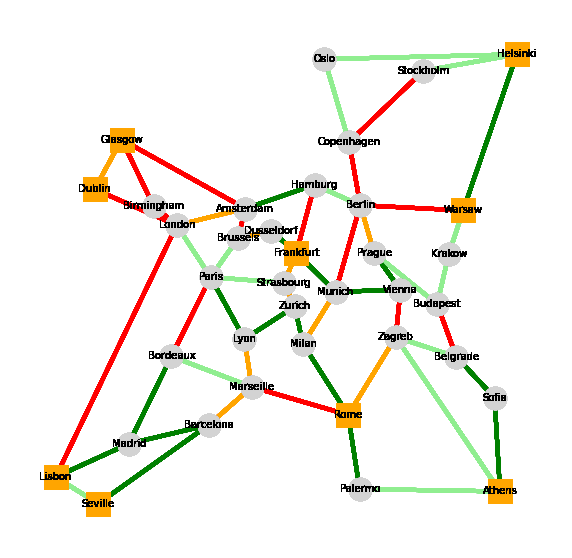

In [30]:
plt.figure(figsize=(10,10));
plt.axis('off')

colors = []
for (u,v) in G.edges():
    if load[(u,v)] > 100:
        colors.append('black')
    elif load[(u,v)] > model.gamma.value *100 - epsilon:
        colors.append('red')
    elif load[(u,v)] > 50:
        colors.append('orange')
    elif load[(u,v)] >=25:
        colors.append('green')
    elif load[(u,v)] >=0:
        colors.append('lightgreen')
    else:
        colors.append('lightgrey')

    nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
    nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color=colors, width=4)

    nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
    nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')